In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def encode(series): 
    return pd.get_dummies(series.astype(str))

In [3]:
train_x = pd.read_csv('../../big datasets/drugml/x_train_res.csv')
train_y = pd.read_csv('../../big datasets/drugml/y_train_res.csv')
test_x = pd.read_csv('../../big datasets/drugml/x_test.csv')
test_y = pd.read_csv('../../big datasets/drugml/y_test.csv')

In [4]:
from sklearn.preprocessing import StandardScaler
xscaler = StandardScaler().fit(train_x)
train_x = xscaler.transform(train_x)
testscaler = StandardScaler().fit(test_x)
test_x = testscaler.transform(test_x)
# https://stackoverflow.com/questions/38058774/scikit-learn-how-to-scale-back-the-y-predicted-result #### use me to get your data back to normal scale!

C:\Users\ellie\Miniconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\ellie\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ellie\Miniconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\ellie\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [5]:
x_train = pd.DataFrame(train_x)
train_y = pd.DataFrame(train_y)
x_test = pd.DataFrame(test_x)
test_y = pd.DataFrame(test_y)

In [6]:
#x_train = x_train.drop(['Unnamed: 0'], axis=1)

train_y = train_y.drop(['Unnamed: 0'], axis=1)
y_train = encode(train_y)
#y_train = encode(train_y)
#x_test = test_x.drop(['Unnamed: 0'], axis=1)
test_y = test_y.drop(['Unnamed: 0'], axis=1)
y_test = encode(test_y)
#y_test = encode(test_y)

In [7]:
x_train['Class-1'] = y_train.iloc[:,0]
x_train['Class-2'] = y_train.iloc[:,1]
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,272,273,274,275,276,277,278,279,Class-1,Class-2
0,-1.730986,0.921982,-0.157973,-1.459674,0.334478,0.369859,0.428547,1.187530,-0.313013,-0.179779,...,0.877483,0.613616,-0.820161,-0.338000,0.806019,0.234209,1.225323,-1.425786,0,1
1,-1.728855,0.855233,-0.157973,-1.165434,-0.087522,0.817984,1.128209,0.677041,2.486413,-0.179779,...,0.937737,1.266806,0.683059,-0.337961,0.963520,0.346804,1.350914,-0.382318,0,1
2,-1.726725,-0.490926,-0.157973,-0.092644,-0.689763,0.821746,0.428547,0.166552,-0.313013,-0.179779,...,0.924800,0.617204,-0.217306,-0.337907,0.784516,0.449160,0.220684,-0.429355,0,1
3,-1.724595,1.783538,-0.157973,-2.115771,1.673549,0.956781,2.527533,-0.854426,-0.313013,-0.179779,...,0.729878,0.575758,-0.049837,-0.337926,1.128384,0.467271,0.824613,-0.956659,0,1
4,-1.722464,1.576920,-0.157973,-0.512310,-0.629174,0.681700,0.428547,0.166552,-0.313013,-0.179779,...,1.639030,2.540884,1.382322,-0.338042,0.779403,0.436493,0.351273,-0.689293,0,1


In [8]:
print(len(x_train[x_train['Class-1'] == 1]), len(x_train[x_train['Class-2'] == 1]))
y_train.head()
train_y.head() #first 813 are positive

813 813


,0
0,1
1,1
2,1
3,1
4,1


In [9]:
### drop negative examples from features
selected = train_y.iloc[:810,:]
#selected.head()
#listed_y= list(selected)

samples = x_train.iloc[:810,:280]
#samples['Class'] = selected
#samples.head()

In [10]:
full = x_train.iloc[:,:280]
full_selected = train_y.iloc[:,:]
full['Class'] = full_selected

ValueError: Trying to share variable GAN/Discriminator/dense/kernel, but specified shape (2, 16) and found shape (280, 16).

In [11]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

def generator(Z,hsize=[280, 280],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,280)

    return out

def discriminator(X,hsize=[280, 280],reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,280) # h2,2
        out = tf.layers.dense(h3,1)

    return out, h3


X = tf.placeholder(tf.float32,[None,280])
Z = tf.placeholder(tf.float32,[None,280])

G_sample = generator(Z)
r_logits, r_rep = discriminator(X)
f_logits, g_rep = discriminator(G_sample,reuse=True)

disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))

gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step



# sess = tf.Session(config=config)
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 30
nd_steps = 10
ng_steps = 10

#x_plot = samples.iloc[:30,:]

#f = open('loss_logs.csv','w')
#f.write('Iteration,Discriminator Loss,Generator Loss\n')

#total_batch = int(len(samples) / batch_size)



saved = []
for i in range(100):
    rndperm = np.random.permutation(samples.shape[0])
    x_batches = np.array_split(rndperm, batch_size)
    X_batch = x_batches
    Z_batch = sample_Z(batch_size, 280)

    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

    rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
    #if i%10 == 0:
        #f.write("%d,%f,%f\n"%(i,dloss,gloss))
    # data.to_csv('data/' + 'credicard.engineered.csv.zip')
    
    save = sess.run(G_sample, feed_dict={Z: Z_batch})
    saved.append(save)


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


ValueError: Cannot feed value of shape (30, 27) for Tensor 'Placeholder:0', which has shape '(?, 280)'

In [ ]:
generated =  pd.DataFrame(np.concatenate(saved))
generated.shape

In [ ]:
check = generated.iloc[780:810,:].copy()
syn = []
for index, row in check.iterrows():
    syn.append(1)
check['Class'] = syn
    

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1626 samples in 0.048s...
[t-SNE] Computed neighbors for 1626 samples in 2.656s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1626
[t-SNE] Computed conditional probabilities for sample 1626 / 1626
[t-SNE] Mean sigma: 6.121341
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.969353
[t-SNE] KL divergence after 300 iterations: 0.681787
[t-SNE] Computing 29 nearest neighbors...
[t-SNE] Indexed 30 samples in 0.000s...
[t-SNE] Computed neighbors for 30 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 30 / 30
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.439072
[t-SNE] KL divergence after 300 iterations: 0.549092
t-SNE done!


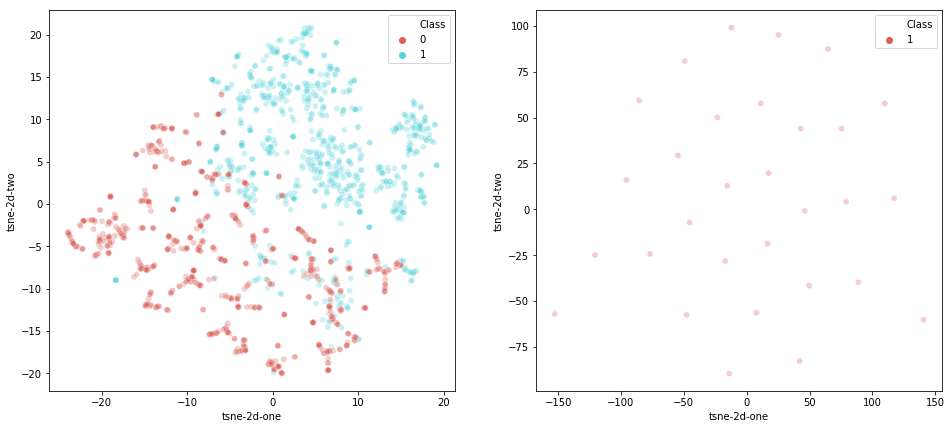

In [24]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=4)
tsne_results1 = tsne.fit_transform(full)
tsne_results2 = tsne.fit_transform(check)
print('t-SNE done!')
full['tsne-2d-one'] = tsne_results1[:,0]
full['tsne-2d-two'] = tsne_results1[:,1]
check['tsne-2d-one'] = tsne_results2[:,0]
check['tsne-2d-two'] = tsne_results2[:,1]
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
   x="tsne-2d-one", y="tsne-2d-two",
    hue="Class",
    palette=sns.color_palette("hls", 2),
    data=full,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Class",
    palette=sns.color_palette("hls", 1),
    data=check,
    legend="full",
    alpha=0.3,
    ax=ax2
)

In [19]:
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

pca = PCA(n_components=3)
pca_result = pca.fit_transform(full.values)
full['pca-one'] = pca_result[:,0]
full['pca-two'] = pca_result[:,1] 
full['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


rndperm = np.random.permutation(full.shape[0])
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=full["pca-one"], y=full["pca-two"], hue='Class',
    palette=sns.color_palette("hls", 1),
    data=full.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1626 samples in 0.041s...
[t-SNE] Computed neighbors for 1626 samples in 3.037s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1626
[t-SNE] Computed conditional probabilities for sample 1626 / 1626
[t-SNE] Mean sigma: 5.650933
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.652206
[t-SNE] KL divergence after 300 iterations: 1.246144
t-SNE done!


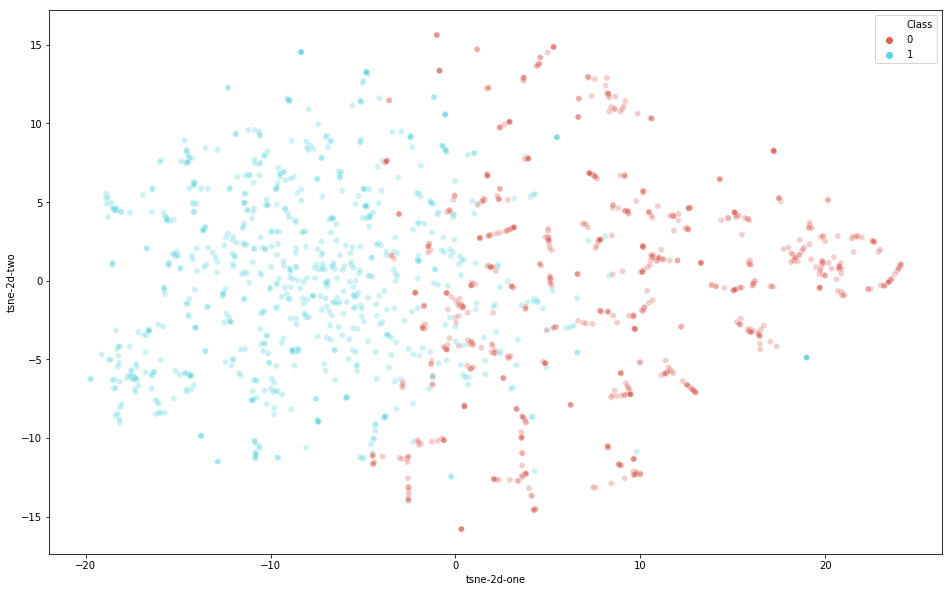

In [20]:

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(full)
print('t-SNE done!')
full['tsne-2d-one'] = tsne_results[:,0]
full['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue='Class',
    palette=sns.color_palette("hls", 2),
    data=full,
    legend="full",
    alpha=0.3
)

In [ ]:
samples['pca-four'] = pca_result[:,3]
samples['pca-five'] = pca_result[:,4]
samples['pca-six'] = pca_result[:,5]
samples['pca-seven'] = pca_result[:,6]
samples['pca-eight'] = pca_result[:,7]
samples['pca-nine'] = pca_result[:,8]
samples['pca-ten'] = pca_result[:,9]

In [ ]:
# https://github.com/aadilh/blogs/blob/new/basic-gans/basic-gans/code/gan.py  
        #### training data
    
    
  if i%10 == 0:
        plt.figure()
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        #xax = plt.scatter(x_plot[:,:], x_plot[:,:])
        gax = plt.scatter(g_plot[:,0],g_plot[:,1])
        #plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()
        #plt.savefig('../plots/iterations/iteration_%d.png'%i)
        plt.show()
        plt.close()

        plt.figure()
        rrd = plt.scatter(rrep_dstep[:,0], rrep_dstep[:,1], alpha=0.5)
        rrg = plt.scatter(rrep_gstep[:,0], rrep_gstep[:,1], alpha=0.5)
        grd = plt.scatter(grep_dstep[:,0], grep_dstep[:,1], alpha=0.5)
        grg = plt.scatter(grep_gstep[:,0], grep_gstep[:,1], alpha=0.5)
        plt.legend((rrd, rrg, grd, grg), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))
        plt.title('Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        #plt.savefig('../plots/features/feature_transform_%d.png'%i)
        plt.close()

        plt.figure()

        rrdc = plt.scatter(np.mean(rrep_dstep[:,0]), np.mean(rrep_dstep[:,1]),s=100, alpha=0.5)
        rrgc = plt.scatter(np.mean(rrep_gstep[:,0]), np.mean(rrep_gstep[:,1]),s=100, alpha=0.5)
        grdc = plt.scatter(np.mean(grep_dstep[:,0]), np.mean(grep_dstep[:,1]),s=100, alpha=0.5)
        grgc = plt.scatter(np.mean(grep_gstep[:,0]), np.mean(grep_gstep[:,1]),s=100, alpha=0.5)
        plt.legend((rrdc, rrgc, grdc, grgc), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))

        plt.title('Centroid of Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        #plt.savefig('../plots/features/feature_transform_centroid_%d.png'%i)
        plt.close()   
            
#import numpy as np
#import math


#def get_y(x):
#    return 10 + x*x


#def sample_data(n=10000, scale=100):
#    data = []

#    x = scale*(np.random.random_sample((n,))-0.5)

 #   for i in range(n):
  #      yi = get_y(x[i])
   #     data.append([x[i], yi])

    #return np.array(data)

 ___________________________________________________________________

def generator(z,reuse=None):
    with tf.variable_scope('gen', reuse=reuse):
        hidden1=tf.layers.dense(inputs=z, units=60, activation=tf.nn.leaky_relu)
        hidden2=tf.layers.dense(inputs=hidden1, units=60, activation=tf.nn.leaky_relu)
        output=tf.layers.dense(inputs=hidden2, units=280, activation=tf.nn.tanh)
        
        return output

def discriminator(x, reuse=None):
    with tf.variable_scope('dis', reuse=reuse):
        hidden1=tf.layers.dense(inputs=x, units=60, activation=tf.nn.leaky_relu)
        hidden2=tf.layers.dense(inputs=hidden1, units=60, activation=tf.nn.leaky_relu)
        logits=tf.layers.dense(hidden2, units=280)
        output=tf.sigmoid(logits)
        
        return output, logits
    ### discriminator should be similar to what i have in the nn

tf.reset_default_graph()

real_molecules=tf.placeholder(tf.float32, shape=[None,280])
z = tf.placeholder(tf.float32, shape=[None,280])

G = generator(z)
D_output_real,D_logits_real = discriminator(real_molecules)
D_output_fake,D_logits_fake = discriminator(G, reuse=True)

def loss_func(logits_in, labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in, labels=labels_in))
                          
D_real_loss = loss_func(D_logits_real,tf.ones_like(D_logits_real)*0.9)
D_fake_loss = loss_func(D_logits_fake, tf.zeros_like(D_logits_real))
D_loss=D_real_loss + D_fake_loss
                          
G_loss = loss_func(D_logits_fake, tf.ones_like(D_logits_fake))

lr=0.001

tvars=tf.trainable_variables()  #returns all variables created(the two variable scopes) and makes trainable true
d_vars=[var for var in tvars if 'dis' in var.name]
g_vars=[var for var in tvars if 'gen' in var.name]

D_trainer=tf.train.AdamOptimizer(lr).minimize(D_loss,var_list=d_vars)
G_trainer=tf.train.AdamOptimizer(lr).minimize(G_loss,var_list=g_vars)

batch_size=100
epochs=100
init=tf.global_variables_initializer()

samples = []

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        #num_batches=mnist.train.num_examples//batch_size
        num_batches = int(len(x_train)/batch_size)
        x_batches = np.array_split(x_train, num_batches)
        y_batches = np.array_split(y_train, num_batches)
        for i in range(num_batches):
            #batch=mnist.train.next_batch(batch_size)
            batch_x, batch_y = x_batches[i], y_batches[i]
            
            batch_mols=batch_x[0] + batch_y[0] #reshape((batch_size,280))
            batch_mols=batch_mols*2-1
            batch_z=np.random.uniform(-1,1,size=(batch_size,280))
            _=sess.run(D_trainer,feed_dict={real_molecules:batch_mols,z:batch_z})
            _=sess.run(G_trainer,feed_dict={z:batch_z})
            
        print("on epoch{}".format(epoch))
        
        sample_z=np.random.uniform(-1,1,size=(1,100))
        gen_sample=sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
        
        samples.append(gen_sample)
  